In [1]:
import crocoddyl
import numpy as np
import matplotlib.pyplot as plt 
import utils.unicycle as uni
from utils.plotting import plot_control_sequence, plot_state_trajectory, plot_cost, plot_convergence
from models.cartpole import ActionModelCartpole, ActionDataCartpole
from utils.cartpole_utils import animateCartpole
from IPython.display import HTML


from MPPI.mppi import MPPI, MPPILogger
from MPPI.mppi_ddp import MPPIDDP

In [2]:
# Fix random seed

np.random.seed(0)

## Defining the problem

Write states, u etc.

In [3]:
# crocoddyl.ActionModelCodeGen

In [4]:
# Create an action model, data, and its NumDiff's action
model = ActionModelCartpole()
model_term = ActionModelCartpole()
data = model.createData()

# Compute analytical and NumDiff derivatives
# Create a shooting problem with 50 running nodes (i.e., 50 * 5e-2 = 2.5 sec)
T = 50
x0 = np.array([0.0, 0.0, 1.0, 0.5])


## Solving the OCP with DDP

In [5]:
problem = crocoddyl.ShootingProblem(x0, [ model ] * T, model_term)

u_nom = np.zeros((T, 1))

mppi_solver_check = MPPI(model, model_term, T, 1, 1, np.full(1, 0.1))
x_nom, _ = mppi_solver_check.rollout_trajectory(x0, u_nom)

ddp = crocoddyl.SolverDDP(problem)
ddp.setCallbacks([crocoddyl.CallbackLogger(), crocoddyl.CallbackVerbose()])
# conv = ddp.solve(init_us=list(u_nom), init_xs=list(x_nom), maxiter=30)
ddp.solve()
print(f"Final DDP cost: {ddp.cost}")

iter    cost       merit      stop      |grad|      preg       dreg      step   ||ffeas||  ||gfeas||  ||hfeas||   dV-exp       dV      dPhi-exp     dPhi
   0  4.844e+00  0.000e+00  0.000e+00  0.000e+00  1.000e-09  1.000e-09  1.0000  1.000e+00  0.000e+00  0.000e+00  0.000e+00 -4.844e+00  0.000e+00  0.000e+00
Final DDP cost: 4.843614219835456
   1  4.844e+00  0.000e+00  2.809e-06  5.618e-06  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  2.809e-06  2.806e-06  0.000e+00  0.000e+00
   2  4.844e+00  0.000e+00  3.516e-12  7.033e-12  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  3.516e-12  3.510e-12  0.000e+00  0.000e+00


In [6]:
log = ddp.getCallbacks()[0]
u_opt_ddp = np.array(log.us)
# plot_control_sequence(u_opt_ddp)

x_opt_ddp = np.array(log.xs)
ddp_costs = log.costs
# plot_state_trajectory(x_opt_ddp)

# plot_cost(log.costs)
# plot_convergence(log.costs)

In [7]:
# crocoddyl.plotConvergence(
#     log.costs,
#     log.pregs,
#     log.dregs,
#     log.grads,
#     log.stops,
#     log.steps,
#     figIndex=2,
#     show=False,
# )

## Solving the OCP with MPPI

In [8]:
# MPPI parameters
horizon = T         # Number of time steps in the prediction horizon
num_samples = 100    # Number of control samples
lambda_param = 10    # Temperature parameter
noise_std = np.array([0.1]) # Std dev for [linear_vel_noise, angular_vel_noise]
n_iter = 30

# Logging
logger_mppi = MPPILogger(enable_logging=True, n_log=5)


print("Running MPPI solver...")
mppi_solver = MPPI(model, model_term, horizon, num_samples, lambda_param, noise_std, param_exploration=0.0, n_filt=5, logger=logger_mppi)
u_opt_mppi = mppi_solver.solve(x0, num_iterations=n_iter)

print("\nRolling out trajectory with optimal controls...")
x_opt_mppi, mppi_final_cost = mppi_solver.rollout_trajectory(x0, u_opt_mppi)
# Store the final optimized nominal control sequence in the logger
logger_mppi.set_final_controls(u_opt_mppi)
logger_mppi.set_final_state(x_opt_mppi)

print(f"Final cost of optimal trajectory: {mppi_final_cost:.4f}")

Running MPPI solver...
Iteration 1/30, Min Cost: 18.4647, Mean Cost: 22.9192
Iteration 2/30, Min Cost: 18.3868, Mean Cost: 22.2074
Iteration 3/30, Min Cost: 18.3946, Mean Cost: 21.8748
Iteration 4/30, Min Cost: 18.3783, Mean Cost: 22.1213
Iteration 5/30, Min Cost: 18.3750, Mean Cost: 21.1851
Iteration 6/30, Min Cost: 18.3833, Mean Cost: 20.6067
Iteration 7/30, Min Cost: 18.3734, Mean Cost: 20.6433
Iteration 8/30, Min Cost: 18.3597, Mean Cost: 20.4133
Iteration 9/30, Min Cost: 18.3944, Mean Cost: 20.4534
Iteration 10/30, Min Cost: 18.3523, Mean Cost: 20.3566
Iteration 11/30, Min Cost: 18.3565, Mean Cost: 20.1633
Iteration 12/30, Min Cost: 18.3730, Mean Cost: 20.2674
Iteration 13/30, Min Cost: 18.3934, Mean Cost: 20.2180
Iteration 14/30, Min Cost: 18.3805, Mean Cost: 20.3466
Iteration 15/30, Min Cost: 18.3891, Mean Cost: 20.2084
Iteration 16/30, Min Cost: 18.3941, Mean Cost: 20.1794
Iteration 17/30, Min Cost: 18.3584, Mean Cost: 20.1156
Iteration 18/30, Min Cost: 18.3747, Mean Cost: 20.2

In [9]:
# logger.plot_sampled_cost_histogram(iteration_index_in_log=2, bins=30)
# logger.plot_weights_histogram(iteration_index_in_log=1, bins=10)


## Plots

array([<Axes: title={'center': 'State Trajectory'}>, <Axes: >, <Axes: >,
       <Axes: xlabel='Time Step (Horizon + 1)'>], dtype=object)

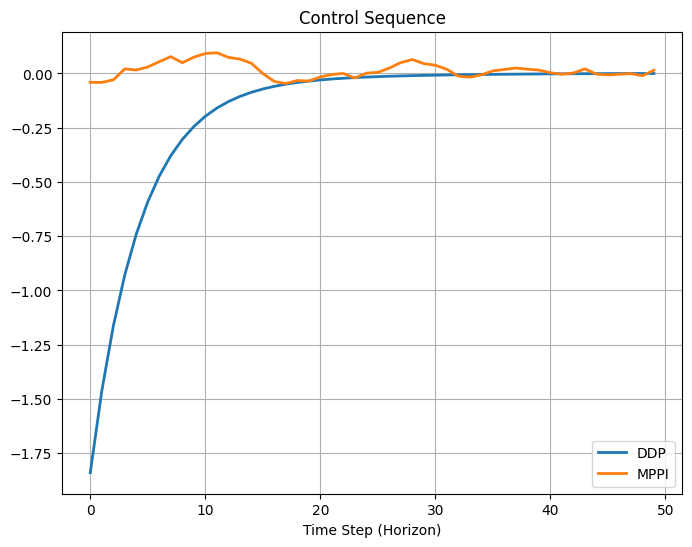

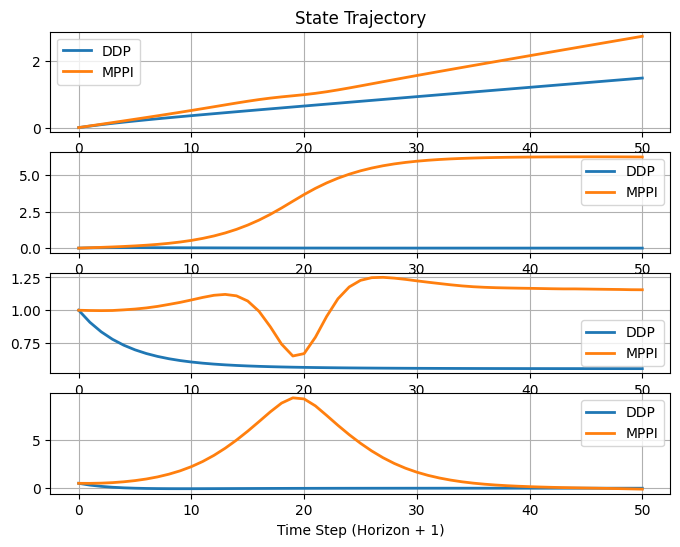

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
plot_control_sequence(u_opt_ddp, [axs], labels=["DDP"]*1)
plot_control_sequence(u_opt_mppi, [axs], labels=["MPPI"]*1)

fig, axs = plt.subplots(4, 1, figsize=(8, 6))
plot_state_trajectory(x_opt_ddp, axs, labels=["DDP"]*4)
plot_state_trajectory(x_opt_mppi, axs, labels=["MPPI"]*4)

In [11]:
u_opt_ddp.shape

(50, 1)

## Solving OCP with MPPI-DDP

In [12]:
# MPPI parameters
horizon = T         # Number of time steps in the prediction horizon
num_samples = 1    # Number of control samples
lambda_param = 1    # Temperature parameter
noise_std = np.array([0.1]) # Std dev for [linear_vel_noise, angular_vel_noise]
n_iter = 3


# Logging
logger_mppi_ddp = MPPILogger(enable_logging=True, n_log=5)

print("Running MPPI-DDP solver...")
# FIX: Add 'problem' as the ddp_problem argument
mppi_ddp_solver = MPPIDDP(model, model_term, horizon, num_samples, lambda_param, noise_std,
                      ddp_problem=problem,
                      param_exploration=0.0, n_filt=5, logger=logger_mppi_ddp,
                      num_ddp_replace=1)
u_opt_mppi_ddp = mppi_ddp_solver.solve(x0, num_iterations=n_iter)

print("\nRolling out trajectory with optimal controls...")
x_opt_mppi_ddp, final_cost_mppi_ddp = mppi_ddp_solver.rollout_trajectory(x0, u_opt_mppi_ddp)
# Store the final optimized nominal control sequence in the logger
logger_mppi_ddp.set_final_controls(u_opt_mppi_ddp)
logger_mppi_ddp.set_final_state(x_opt_mppi_ddp)

print(f"Final cost of optimal trajectory: {final_cost_mppi_ddp:.4f}")

Running MPPI-DDP solver...
Iteration 1/3, Min Cost: 42.2882, Mean Cost: 42.2882, DDP Cost: 42.2882, DDP converged: False
Iteration 2/3, Min Cost: 19.0652, Mean Cost: 19.0652, DDP Cost: 19.0652, DDP converged: False
Iteration 3/3, Min Cost: 18.7458, Mean Cost: 18.7458, DDP Cost: 18.7458, DDP converged: False

Rolling out trajectory with optimal controls...
Final cost of optimal trajectory: 19.1492


processing the animation ... 
... processing done


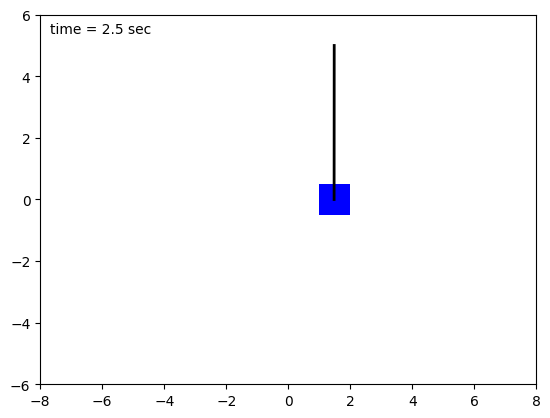

In [13]:
anim = animateCartpole(ddp.xs)
HTML(anim.to_jshtml())

processing the animation ... 
... processing done


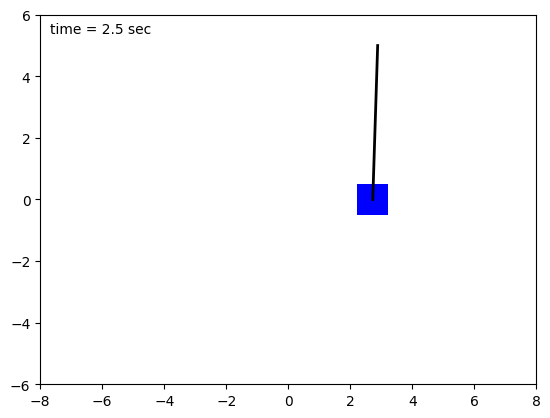

In [14]:
anim = animateCartpole(x_opt_mppi)
HTML(anim.to_jshtml())

processing the animation ... 
... processing done


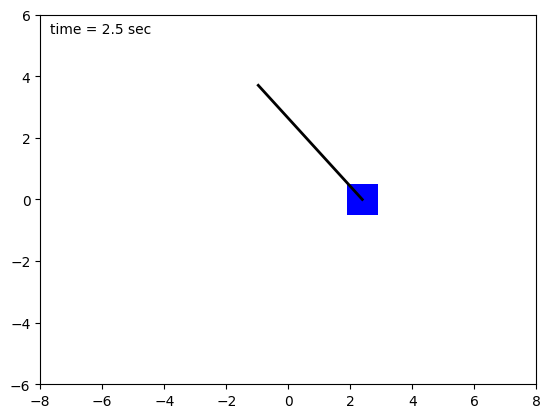

In [15]:
anim = animateCartpole(x_opt_mppi_ddp)
HTML(anim.to_jshtml())

array([<Axes: title={'center': 'State Trajectory'}>, <Axes: >, <Axes: >,
       <Axes: xlabel='Time Step (Horizon + 1)'>], dtype=object)

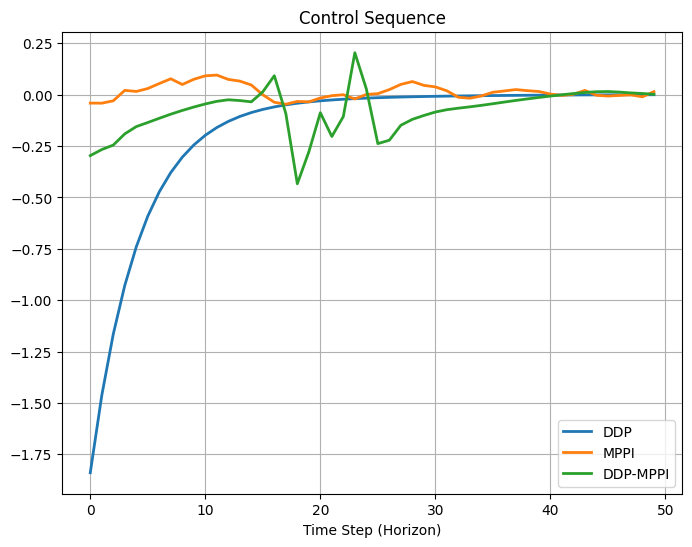

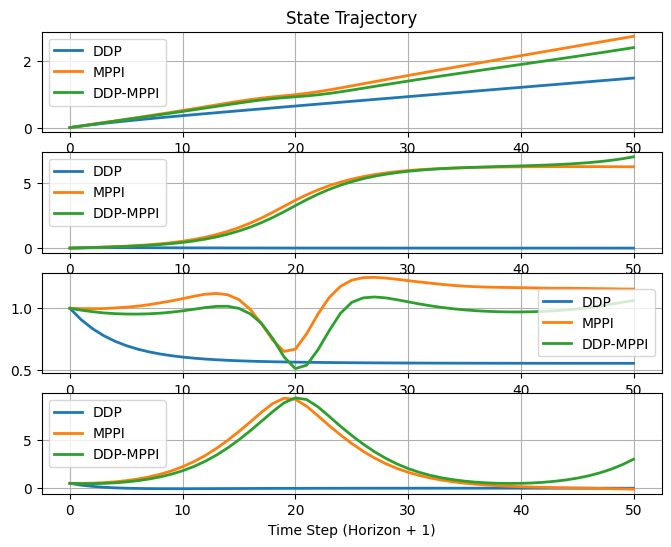

In [16]:
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
plot_control_sequence(u_opt_ddp, [axs], labels=["DDP"]*1)
plot_control_sequence(u_opt_mppi, [axs], labels=["MPPI"]*1)
plot_control_sequence(u_opt_mppi_ddp, [axs], labels=["DDP-MPPI"]*1) # Added DDP-MPPI control sequence

fig, axs = plt.subplots(4, 1, figsize=(8, 6))
plot_state_trajectory(x_opt_ddp, axs, labels=["DDP"]*4)
plot_state_trajectory(x_opt_mppi, axs, labels=["MPPI"]*4)
plot_state_trajectory(x_opt_mppi_ddp, axs, labels=["DDP-MPPI"]*4) # Added DDP-MPPI state trajectory

(10.0, 50.0)

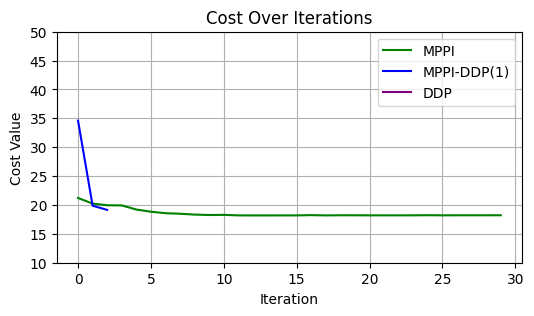

In [17]:
# Create a figure and a single subplot for the cost histories
fig, ax = plt.subplots(1, 1, figsize=(6, 3)) # [2]

# Plot each cost history on the same subplot
plot_cost(logger_mppi.total_cost_hist, ax=ax, color="green",  label="MPPI") 
plot_cost(logger_mppi_ddp.total_cost_hist, ax=ax, color="blue", label="MPPI-DDP(1)")
plot_cost(ddp_costs, ax=ax, color="purple", label="DDP")
ax.legend()
ax.set_ylim(10, 50)

(-100.0, 10.0)

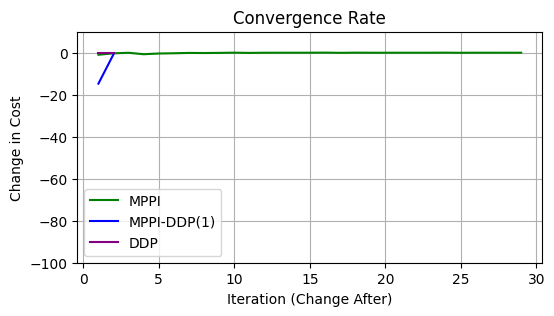

In [18]:
# Create a figure and a single subplot for the cost histories
fig, ax = plt.subplots(1, 1, figsize=(6, 3)) # [2]

# Plot each cost history on the same subplot
plot_convergence(logger_mppi.total_cost_hist, ax=ax, color="green",  label="MPPI") 
plot_convergence(logger_mppi_ddp.total_cost_hist, ax=ax, color="blue", label="MPPI-DDP(1)")
plot_convergence(ddp_costs, ax=ax, color="purple", label="DDP")
ax.legend()
ax.set_ylim(-100, 10)